In [20]:
import numpy as np
from numpy import ndarray
import math
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as p

# Part III
### Learning

Construct simulated data for testing learning implementation

In [21]:

def forward_sim(n, T, alpha=0.9, gamma=0.1, beta=0.2, lmda=(1, 5)): 
    """
    Returns C, Z, X
    """
    # Transition probability matrix for the HMM, parameterized by gamma and beta (Transition probabilities of switching between states C in {0, 1, 2}).
    Gamma = np.array([[1-gamma, 0, gamma], [0, 1-gamma, gamma], [beta*0.5, beta*0.5, 1-beta]])
    Z_prob = [[alpha, 1-alpha], [1-alpha, alpha], [0.5, 0.5]]
    
    # Initialize arrays
    C = np.zeros(T, dtype=int)
    Z = np.zeros((T, n), dtype=int)
    X = np.zeros((T, n), dtype=int)

    # Simulate the proces for the remaining t=1 to t=T timesteps
    for t in range(T):
        C[t] = random.choices([0, 1, 2], Gamma[2 if t == 0 else C[t-1]])[0] # First state is 0, every other picked random via the Gamma transition matrix
        for i in range(0, n):
            Z[t, i] = random.choices([0, 1], Z_prob[C[t]])[0] # Simulated hidden variables Z drawn from the distribution P(Z|C)
            X[t, i] = np.random.poisson(lam = lmda[Z[t, i]]) # Simulated observed variables drawn at random from the poisson distribution.

    return C, Z, X

### Initialization

In [22]:
# The C_0 vector which would correspond to C[-1], but is redundant for the purposes of the C array, 
# which corresponds to a C for every T. In reality we have T+1 C variables and T x N Z and X variables.
C_initial = np.array([0, 0, 1]) 

In [23]:
# Function for P(X|Z)
def PX_given_Z(x, z, lmda: tuple):
    e = np.exp((-1)* lmda[z])
    x_fact = math.factorial(x)
    denom = np.exp(x*np.log(lmda[z])) if np.log(lmda[z]) != 0 else 0 # avoid overflow
    factor = denom/x_fact
    prob = e*factor
    return prob

In [24]:
# Function for P(Z|C)
def PZ_given_C(c, z, _alpha):
    Z_prob = np.array([[_alpha, 1-_alpha], [1-_alpha, _alpha], [0.5, 0.5]])
    return Z_prob[c, z]

In [25]:
def Z_inferred(X: ndarray, lmda: tuple) -> ndarray:
    #For every observed X=x, we calculate the conditional probaility P(Z=0|X=x)
    #We use Bayes theorem to do this. 

    T, n = X.shape

    Z_inferred = np.zeros((T, n, 2), dtype=float) 

    Z_marg = (0.5, 0.5) #We assume that P(Z=0) = 0.5 due to the distribution of Z | C, and due to an assumption that P(C=1) = P(C=0)

    #We start by calculating P(X) for every observed X and save them in a table. It doesn't make sense to compute P(X) for unobserved values of X
    X_marg = np.zeros(np.max(X) + 1)
    #We calculate P(X) using the formula: P(X=x) = P(X=x|Z=0)P(Z=0) + P(X=x|Z=1)P(Z=1)
    #This works because Z ony takes values in {0,1}. We simply obtain the joint distribution P(X,Z) and sum out Z

    for i in range(len(X_marg)):
        X_marg[i] = PX_given_Z(i, 0, lmda)*Z_marg[0] + PX_given_Z(i, 1, lmda)*Z_marg[1] 
    #X_marg[i] holds the answer for the query P(X=i), Likewise Z_marg[i] holds the answer for the query p(Z=i)

    #For every observed X=x, we calculate the conditional probaility P(Z=0|X=x)
    #We use Bayes theorem to do this. 
    for i in range(Z_inferred.shape[0]): 
        for j in range(Z_inferred.shape[1]): 
            Z_inferred[i, j, 0] = (PX_given_Z(X[i, j], 0, lmda)*Z_marg[0])/(X_marg[X[i, j]])
            Z_inferred[i, j, 1] = 1 - Z_inferred[i, j, 0] 
    return Z_inferred


In [26]:
# Helper function for Forward Algorithm
def calc_emission_proba(X: ndarray, t: int, c: int, lmda: tuple, alpha: float) -> float:
    """
    Calculates the emission probabilities at timestep t
    The probabilities given by P(X_1,t...X_n,t|C_t)
    P(Z|C) by function PZ_given_C(c, z)
    P(X|Z) Poisson distribution given by PX_given_Z(x, z)
    """
    n = X.shape[1]

    emission_proba = 0.
    for i in range(n):
        emission_proba += np.log(PZ_given_C(c, 0, alpha)*PX_given_Z(X[t, i], 0, lmda) + PZ_given_C(c, 1, alpha)*PX_given_Z(X[t, i], 1, lmda))
    emission_proba = np.exp(emission_proba)

    return emission_proba

In [27]:
################## Forward Algorithm ##################
def forward(X: ndarray, alpha: float, beta: float, gamma: float, lmda: tuple) -> ndarray:
    """
    Iteratively updates the Alpha_t vectors in the Alpha matrix.
    The Alpha matrix represents the P(C|X) distribution for each timestep T as an T x 3 matrix.
    """

    T = X.shape[0]

    # Initialization of the forward probabilities matrix, Alpha.
    Alpha = np.zeros((T, 3), dtype=float)  # T x 3 matrix P(C|X)

    # Transition probability matrix for the HMM, parameterized by gamma and beta (Transition probabilities of switching between states C in {0, 1, 2}).
    Gamma = np.array([[1-gamma, 0, gamma], [0, 1-gamma, gamma], [beta*0.5, beta*0.5, 1-beta]])

    # Buttom-up approach for updating beliefs alpha_t for forward algorithm on C.
    for t in range(T):
        for c in range(3):
            c_prev = 0. # For calculating SUM_c_t-1 P(C_t|c_t-1)*Alpha_t-1(c_t-1)
            for c_ in range(3):
                c_prev += Gamma[c_, c]*(C_initial[c_] if t == 0 else Alpha[t-1, c_])
            Alpha[t, c] = calc_emission_proba(X, t, c, lmda, alpha)*c_prev # Alpha_t = P(X_1,t,...,X_n,t|C_t) * SUM_c_t-1 P(C_t|c_t-1)*Alpha_t-1(c_t-1)
        row_sum = np.sum(Alpha[t], axis=0) # Normalizing sum for each row
        Alpha[t] = Alpha[t]/row_sum # Row-wise normalization for the CPD, normalizing the unnormalized Gibbs measure of each row.
    return Alpha

In [28]:
def inferred_C_Z(X: ndarray, alpha: float, beta: float, gamma: float, lmda: tuple):
    """
    Infers the CPD of P(C|Z) as an T x 3 Alpha matrix
    And the CPD P(Z|X) as an T x n Z_infered matrix
    """
    Alpha = forward(X, alpha, beta, gamma, lmda)
    Z_inf = Z_inferred(X, lmda)
    return Z_inf, Alpha

### Most Likely C-s and Z-s from inferred probabilities

In [29]:
def cement_data(inferd_Z, inferd_C) -> tuple:
    T, n, _ = inferd_Z.shape
    Z = np.zeros((T,n),dtype=int)
    C = np.zeros(T,dtype=int)

    for t in range(T):
        if C[t] == 0 and np.argmax(inferd_C[t-1]) == 1:
            C[t] = 0 if inferd_C[t-1, 0] > inferd_C[t-1, 2] else 2 
        elif C[t] == 1 and np.argmax(inferd_C[t-1]) == 0:
            C[t] = 1 if inferd_C[t-1, 1] > inferd_C[t-1, 2] else 2
        else:
            C[t] = np.argmax(inferd_C[t])
        for i in range(n):
            Z[t, i] = np.argmax(inferd_Z[t, i]) 
    
    return (Z, C) #liste med 2 entries, Z og C

### Learn Parameters function (for Hard EM)

In [30]:

def learn_param(X: ndarray, Z_hat: ndarray, C_hat: ndarray, alpha: float):
    """ 
    learn_param updates parameters from new infered Z and C
    Input: Array Z with shape [n,T], array C with shape [T,]
    Returns: alpha, beta, gamma, lambda0, lambda1
    """
    T, n = Z_hat.shape
    
    _beta    = 0.
    _gamma   = 0.
    _Z0 = (C_hat == 0).sum() * n
    _Z1 = (C_hat == 1).sum() * n
    _W = (C_hat[:T-1] == 2).sum()

    _lambda0 = X[Z_hat == 0].mean()  # Relative frequence of Xs where corresponding Z_hat = 0
    _lambda1 = X[Z_hat == 1].mean()  # Relative frequence of Xs where corresponding Z_hat = 1
    
    _alpha = ((Z_hat[C_hat == 0] == 0).sum() + (Z_hat[C_hat == 1] == 1).sum())/(_Z0 + _Z1 )
    
    _beta = np.sum(C_hat[:-1] > C_hat[1:])
    _gamma = np.sum(C_hat[:-1] < C_hat[1:])

    _beta = 1/_W * _beta
    _gamma = 1/(T-_W) * _gamma

    
    return _alpha, _beta, _gamma, (_lambda0, _lambda1)

## Hard EM Algorithm

In [31]:
def hard_EM_algo(X: ndarray, alpha: float, beta: float, gamma: float, lmda: tuple, N_iter=10):
    _alpha = alpha
    _beta = beta
    _gamma = gamma
    _lmda = lmda
    for i in range(N_iter):
        Z_hat, C_hat = inferred_C_Z(X, _alpha, _beta, _gamma, _lmda)
        Z_hat, C_hat = cement_data(Z_hat, C_hat)
        _alpha, _beta, _gamma, _lmda = learn_param(X, Z_hat, C_hat, _alpha)
    params: list = [_alpha, _beta, _gamma, _lmda[0], _lmda[1]]

    return params

### Simulate 10 X-s and run hard EM on each with "heuristically" infered inital parameters

In [32]:
all_params = []
for i in range(10):
    _, _, X = forward_sim(10, 100)
    i_alpha, i_beta, i_gamma, i_lmda0, i_lmda1 = random.uniform(0.6, 0.99), random.uniform(0.1, 0.3), random.uniform(0.05, 0.195), random.uniform(0.5, 2.), random.uniform(2., 8.)
    all_params.append(hard_EM_algo(X, i_alpha, i_beta, i_gamma, (i_lmda0, i_lmda1), N_iter=10))


In [33]:
mean_arr = np.array(all_params).mean(axis=0)
np.array(all_params)
mean_arr

array([0.76510231, 0.18366191, 0.28103447, 0.87764263, 5.19547012])

In [34]:
correct_params = np.array([0.9, 0.2, 0.1, 1., 5.])
deviance_in_percentage = np.abs(correct_params - mean_arr)/correct_params
print("Reported deviance in percentage of each param alpha, beta, gamma, lambda0, lambda1:\n", deviance_in_percentage)

Reported deviance in percentage of each param alpha, beta, gamma, lambda0, lambda1:
 [0.14988632 0.08169043 1.81034474 0.12235737 0.03909402]


### Running Hard EM on real data

In [35]:
data_files = ["proj_HMM/Ex_1.csv", "proj_HMM/Ex_2.csv", "proj_HMM/Ex_3.csv", "proj_HMM/Ex_4.csv", "proj_HMM/Ex_5.csv", "proj_HMM/Ex_6.csv", "proj_HMM/Ex_7.csv", "proj_HMM/Ex_8.csv", "proj_HMM/Ex_9.csv", "proj_HMM/Ex_10.csv"]

all_params = []
for i in range(10):
    data_ = np.genfromtxt(data_files[i % len(data_files)], delimiter=",", skip_header=True, dtype=int)
    X = data_[:, 1:]
    i_alpha, i_beta, i_gamma, i_lmda0, i_lmda1 = random.uniform(0.6, 0.99), random.uniform(0.1, 0.25), random.uniform(0.05, 0.195), random.uniform(0.5, 2.), random.uniform(2., 8.)
    all_params.append(hard_EM_algo(X, i_alpha, i_beta, i_gamma, (i_lmda0, i_lmda1), N_iter=40))

In [36]:
data_mean_arr = np.array(all_params).mean(axis=0)
np.array(all_params)
print("Estimated parameters after 40 iterations of EM on the 10 experiments (data):\n", data_mean_arr)

Estimated parameters after 40 iterations of EM on the 10 experiments (data):
 [0.80538419 0.26146187 0.3658804  0.95204982 5.17051732]


**Visualize inference on real data**

In [18]:
def switch_1_and_2(arr):
    for i in range(len(arr)):
        if arr[i] == 1:
            arr[i] = 2
        elif arr[i] == 2:
            arr[i] = 1
    return arr

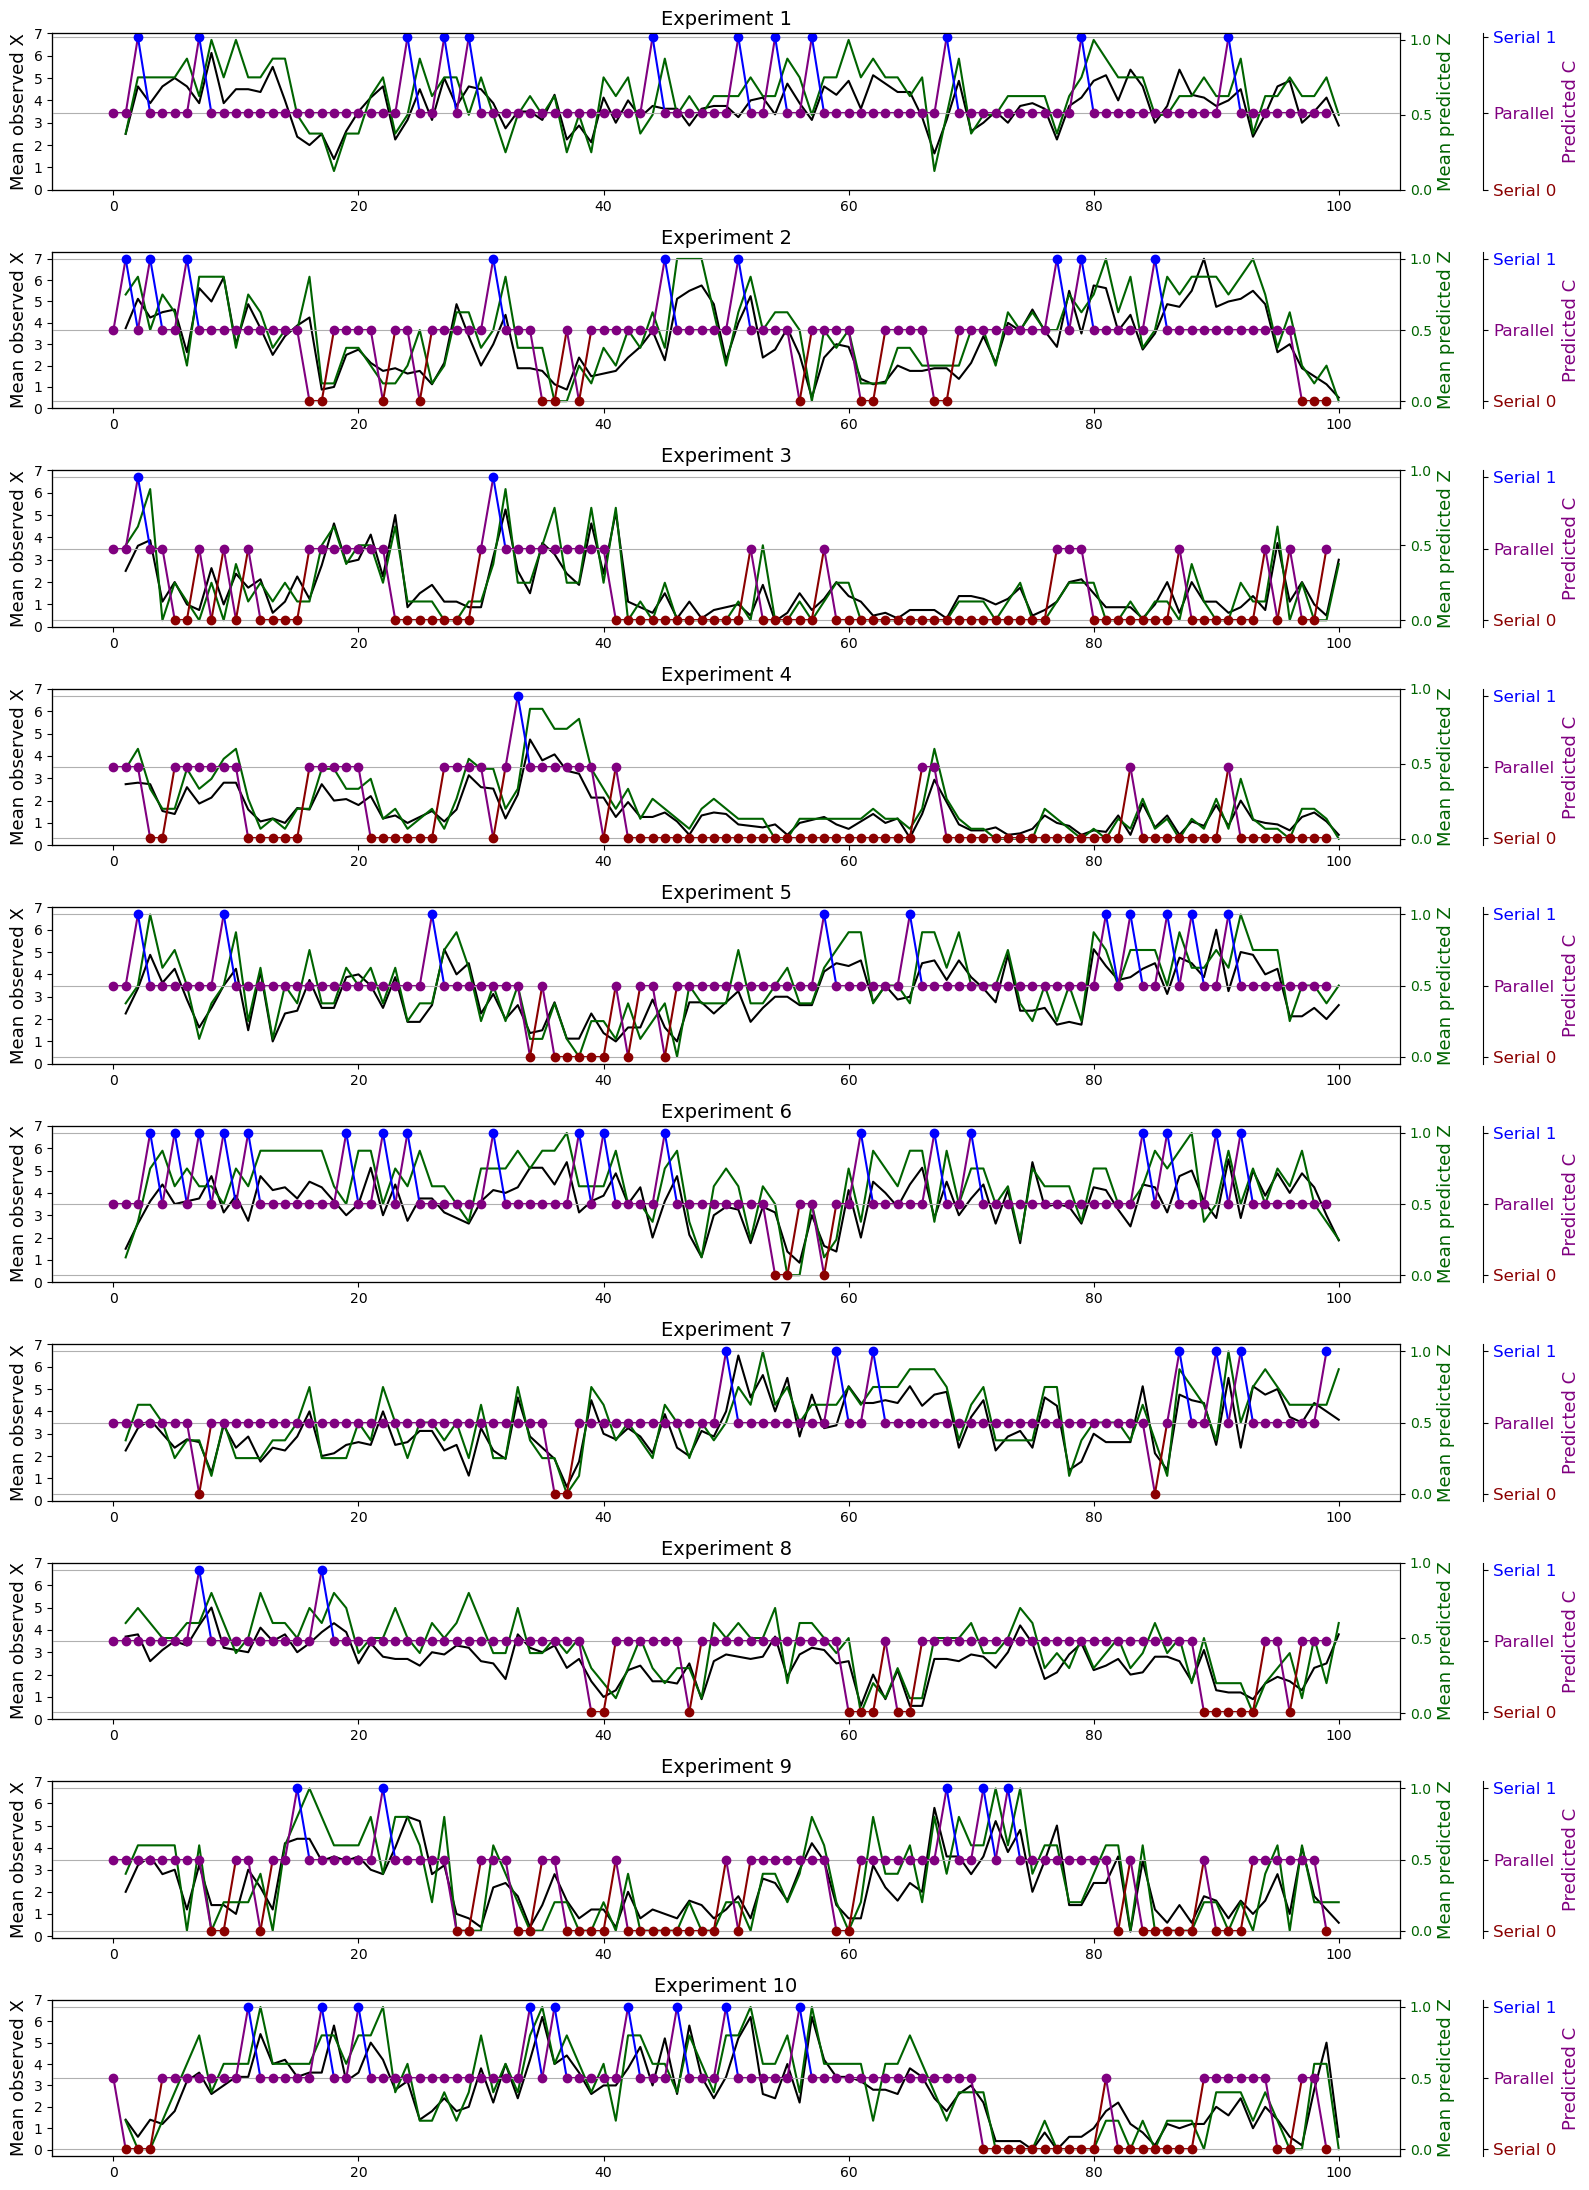

In [19]:
data_files = ["proj_HMM/Ex_1.csv", "proj_HMM/Ex_2.csv", "proj_HMM/Ex_3.csv", "proj_HMM/Ex_4.csv", "proj_HMM/Ex_5.csv", "proj_HMM/Ex_6.csv", "proj_HMM/Ex_7.csv", "proj_HMM/Ex_8.csv", "proj_HMM/Ex_9.csv", "proj_HMM/Ex_10.csv"]

# Create a figure and axis array to hold all subplots
fig, axs = plt.subplots(10, 1, figsize=(16, 22), sharex=False)

for i in range(10):
    # Load data for the current iteration
    data_ = np.genfromtxt(data_files[i % len(data_files)], delimiter=",", skip_header=True, dtype=int)
    data = data_[:, 1:]
    T = data.shape[0]  # Time period
    n = data.shape[1]   # Number of neurons

    # Assuming the rest of your plotting code remains the same
    Z_, C_ = inferred_C_Z(data, data_mean_arr[0], data_mean_arr[1], data_mean_arr[2], (data_mean_arr[3], data_mean_arr[4]))

    Z, C = cement_data(Z_, C_)
    C = switch_1_and_2(C)
    avg_Z = np.mean(Z,axis=1).reshape(1,-1)[0]
    avg_X = np.mean(data,axis=1).reshape(1,-1)[0]

    ax1 = axs[i]
    ax1.plot(range(1,T+1), avg_X, color="black", zorder=3)
    ax1.set_yticks([0,1,2, 3, 4, 5, 6, 7])
    ax1.set_ylabel('Mean observed X', color="black",  fontsize=13)
    ax1.tick_params(axis='y', labelcolor="black")

    ax2 = ax1.twinx()
    ax2.plot(range(1,T+1), avg_Z, color="darkgreen", zorder=2)
    ax2.set_yticks([0,0.5,1])
    ax2.set_ylabel('Mean predicted Z', color="darkgreen", fontsize=13)
    ax2.tick_params(axis='y', labelcolor="darkgreen")

    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.set_ylabel('Predicted C', color="purple", fontsize=13)
    for c in range(len(C)):
        if C[c] == 0:
            color = "darkred"
        elif C[c] == 1:
            color = "purple"
        else:
            color = "blue"
        ax3.plot(c, C[c], color=color, marker="o", zorder=2)

    for j in range(len(C) - 1):
        if C[j] != C[j + 1]:
            color = "black"
            if C[j] == 0:
                color = "darkred"
            elif C[j] == 1:
                color = "purple"
            else:
                color = "blue"
            ax3.plot([j, j + 1], [C[j], C[j + 1]], color=color, zorder=1)
        else: 
            if C[j] == 0:
                color = "darkred"
            elif C[j] == 1:
                color = "purple"
            else:
                color = "blue"
            ax3.plot([j, j + 1], [C[j], C[j + 1]], color=color, zorder=1)

    ax3.tick_params(axis='y', labelcolor="purple")
    ax3.set_yticks([0,1,2])
    ax3.set_yticklabels(["Serial 0", "Parallel", "Serial 1"], fontsize = 12)
    tick_labels = ax3.get_yticklabels()
    tick_labels[0].set_color('darkred')
    tick_labels[1].set_color('purple')
    tick_labels[2].set_color('blue')
    plt.title('Experiment ' + str(i+1), fontsize = 14)
    plt.grid(True)

# Adjust layout to prevent overlap of labels
plt.tight_layout()

plt.show()
